# Описание проекта: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.


# Описание услуг

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.


# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

*contract_new.csv — информация о договоре*

    - customerID — идентификатор абонента
    - BeginDate — дата начала действия договора
    - EndDate — дата окончания действия договора
    - Type — тип оплаты: раз в год-два или ежемесячно
    - PaperlessBilling — электронный расчётный лист
    - PaymentMethod — тип платежа
    - MonthlyCharges — расходы за месяц
    - TotalCharges — общие расходы абонента 
<br/>

*personal_new.csv — персональные данные клиента*

    - customerID — идентификатор пользователя
    - gender — пол
    - SeniorCitizen — является ли абонент пенсионером
    - Partner — есть ли у абонента супруг или супруга
    - Dependents — есть ли у абонента дети 
<br/>    

*internet_new.csv — информация об интернет-услугах*

    - customerID — идентификатор пользователя
    - InternetService — тип подключения
    - OnlineSecurity — блокировка опасных сайтов
    - OnlineBackup — облачное хранилище файлов для резервного копирования данных
    - DeviceProtection — антивирус
    - TechSupport — выделенная линия технической поддержки
    - StreamingTV — стриминговое телевидение
    - StreamingMovies — каталог фильмов  
<br/>   

*phone_new.csv — информация об услугах телефонии*

    - customerID — идентификатор пользователя
    - MultipleLines — подключение телефона к нескольким линиям одновременно
    
    
Во всех файлах столбец customerID содержит код клиента.<br/> 
Информация о договорах актуальна на 1 февраля 2020 года.

##  Общая информация

In [1]:
import pandas as pd #импортируем библиотеки
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import re

from sklearn.model_selection import train_test_split, cross_val_score
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, recall_score,  precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier 
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import shap

In [2]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv') # прочитаем csv-файлы

In [3]:
def discover(data):
    display(data.info())
    display(f'Размер данных:{data.shape}') 
    display(f'Количество пропусков:{data.isna().sum()}')
    display(f'Количество дубликатов:{data.duplicated().sum()}') 

Посмотрим каждый датасет

**Информация о договоре**

In [4]:
discover(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

'Размер данных:(7043, 8)'

'Количество пропусков:customerID          0\nBeginDate           0\nEndDate             0\nType                0\nPaperlessBilling    0\nPaymentMethod       0\nMonthlyCharges      0\nTotalCharges        0\ndtype: int64'

'Количество дубликатов:0'

In [5]:
contract.head() #посмотрим первые строки

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract.describe() #посмотрим статистическую сводку

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Наименование столбцов приведем к нижнему регистру и snake_case. <br/>
Дубликаты и пропуски отсутствуют. <br/>
Размер данных 7043 строк, 8 столбцов.<br/>

Заменим формат даты с текстового в столбцах даты начала  и дата окончания действия договора.<br/>
Столбец общих расходов абонента приведем к числовому.

---

**Персональные данные клиента**

In [7]:
discover(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

'Размер данных:(7043, 5)'

'Количество пропусков:customerID       0\ngender           0\nSeniorCitizen    0\nPartner          0\nDependents       0\ndtype: int64'

'Количество дубликатов:0'

In [8]:
personal.head() #посмотрим первые строки

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
personal.describe() #посмотрим статистическую сводку

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Наименование столбцов приведем к нижнему регистру и snake_case.<br/>
Дубликаты и пропуски отсутствуют.<br/>

Размер данных 7043 строк, 5 столбцов.<br/>

Количество строк в датасетах о  персональных данных клиентов и информации о договорах совпадает.

---

**Информация об интернет-услугах**

In [10]:
discover(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

'Размер данных:(5517, 8)'

'Количество пропусков:customerID          0\nInternetService     0\nOnlineSecurity      0\nOnlineBackup        0\nDeviceProtection    0\nTechSupport         0\nStreamingTV         0\nStreamingMovies     0\ndtype: int64'

'Количество дубликатов:0'

In [11]:
internet.head() #посмотрим первые строки

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet.describe() #посмотрим статистическую сводку

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9053-JZFKV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Наименование столбцов приведем к нижнему регистру и snake_case.<br/>
Дубликаты и пропуски отсутствуют.<br/>
Размер данных 5517 строк, 8 столбцов.<br/>
  
Не все абоненты пользуются интернет-услугами. 

---

**Информация об услугах телефонии**

In [13]:
discover(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

'Размер данных:(6361, 2)'

'Количество пропусков:customerID       0\nMultipleLines    0\ndtype: int64'

'Количество дубликатов:0'

In [14]:
phone.head() #посмотрим первые строки

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
phone.describe() #посмотрим статистическую сводку

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5619-PTMIK,No
freq,1,3390


Наименование столбцов приведем к нижнему регистру и snake_case.<br/>
Дубликаты и пропуски отсутствуют.<br/>
Размер данных 6361 строк, 2 столбца.<br/>

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
Для всех датасетов приведем к нижнему регистру и snake_case наименование столбцов. <br/>
Дубликаты и пропуски отсутствуют.
    
*Информация о договоре* <br/>
Заменим формат даты с текстового в столбцах даты начала  и дата окончания действия договора.<br/>
Столбец и общих расходов абонента приведем  к  целочисленному.

*Персональные данные клиента*<br/>
Количество строк в датасетах о  персональных данных клиентов и информации о договорах совпадает.
    
*Информация об интернет-услугах*<br/>
Не все абоненты пользуются интернет-услугами. 
    
Дальнейшие изменения внесем после объединения данных.    


## Предобработка и анализ данных

Приведем названия столбцов во всех датасетах к snake_case

In [16]:
def snake_case(df):
    new_columns = []
    for col in df.columns:
        new_columns.append(re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower())
    df.columns = new_columns
    return df

In [17]:
contract = snake_case(contract)
personal = snake_case(personal)
internet = snake_case(internet)
phone = snake_case(phone)

In [18]:
contract.head() #проверим

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [19]:
contract.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
personal.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
internet.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
phone.rename(columns={'customer_i_d': 'customer_id'}, inplace=True) 
#поменяем вручную назания столбцов с идентификаторами пользователя                 

**Информация о договоре**

Заменим формат даты с текстового в столбцах даты начала и окончания действия договора. 

In [20]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format = '%Y-%m-%d') #заменим формат даты

In [21]:
contract['begin_date'].value_counts()

2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64

In [22]:
contract['end_date'].unique() #посмотрим уникальные значения в окончании действия договора

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [23]:
contract['end_date'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-12-01       2
2014-09-01       2
2014-10-01       1
2014-11-01       1
2014-06-01       1
Name: end_date, Length: 67, dtype: int64

Добавим столбец с актуальностью клиента на дату выгрузки данных, где 1 будет показателем ухода клиента.

In [24]:
contract['actual'] = pd.Series(np.where(contract['end_date'].values == 'No', 0, 1), contract.index)

Более 80% абонентов продолжают пользоваться услугами, пропуски заполним датой выгрузки данных 2020-02-01.

In [25]:
contract['end_date'] = contract['end_date'].replace(['No'], ['2020-02-01'])

In [26]:
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d', errors='coerce')

Добавим новый столбец с количеством дней использования услуг.

In [27]:
contract['total_days'] = (contract['end_date'] - contract['begin_date']).dt.days

Столбец общих расходов абонента приведем к числовому типу.

In [28]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

In [29]:
contract.info() #проверим внесеные изменения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   actual             7043 non-null   int64         
 9   total_days         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


В общих расходах абонента появились 11 пропусков, посмотрим детальнее

In [30]:
contract[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,actual,total_days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Эти 11 абонентов заключили договор в дату выгрузки датасета, то есть 1 день и поэтому отсутствуют данные по ним. Заполним пропуски 0.

In [31]:
contract['total_charges'] = contract['total_charges'].fillna(0)

---

### Общий датасет

**Объединим датасеты по идентификатору абонента**

In [32]:
final_data = contract.merge(personal, on = 'customer_id', how = 'left').merge(
                            internet, on = 'customer_id', how = 'left').merge(
                            phone, on = 'customer_id', how = 'left')

In [33]:
final_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,actual,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [34]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   actual             7043 non-null   int64         
 9   total_days         7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

Пропуски в информации об интернет-услугах связаны с неиспользованием абонентами определенных услуг, заполним их 'No'

In [35]:
final_data = final_data.fillna('No')

### Исследовательский анализ данных

#### Общий портрет абонента

**Посмотрим распределение абонентов по различным параметрам**

In [36]:
my_colors = ['lightblue','darksalmon', 'silver','antiquewhite']

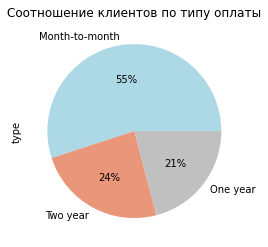

In [37]:
final_data['type'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение клиентов по типу оплаты');

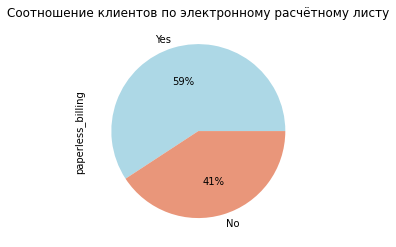

In [38]:
final_data['paperless_billing'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение клиентов по электронному расчётному листу');

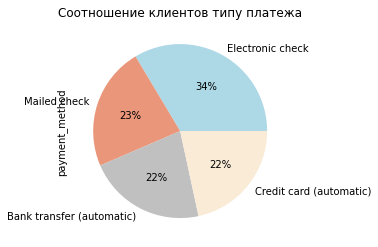

In [39]:
final_data['payment_method'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение клиентов типу платежа');

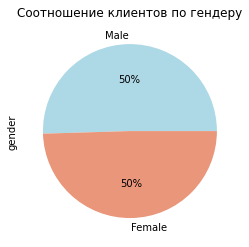

In [40]:
final_data['gender'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение клиентов по гендеру');

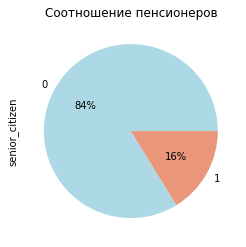

In [41]:
final_data['senior_citizen'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение пенсионеров');

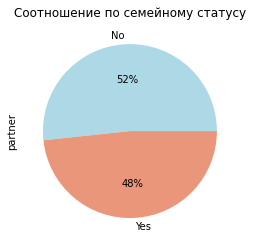

In [42]:
final_data['partner'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение по семейному статусу');

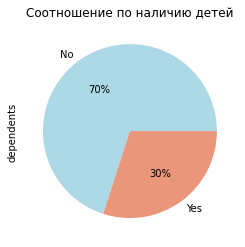

In [43]:
final_data['dependents'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение по наличию детей');

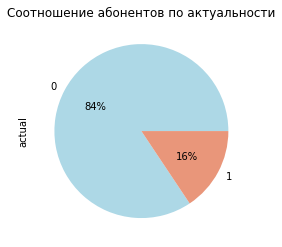

In [44]:
final_data['actual'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение абонентов по актуальности');

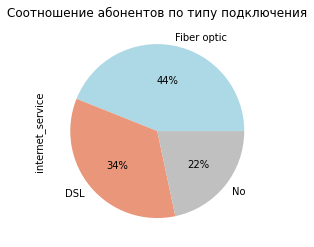

In [45]:
final_data['internet_service'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение абонентов по типу подключения');

Распределение времени действия договора в днях


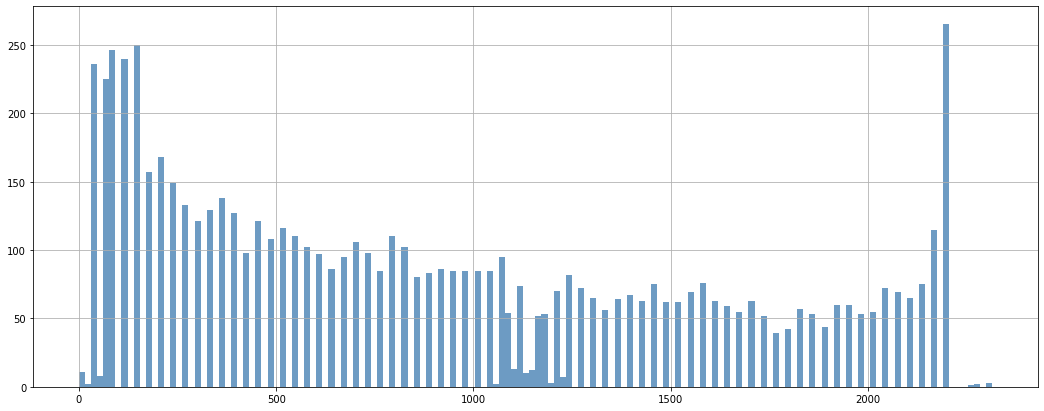

In [46]:
final_data['total_days'].hist(figsize=(18, 7), bins=150, color='#6d9bc3')
print('Распределение времени действия договора в днях')

Видим пиковые значения до года и более 6 лет, менее всего абонентов пользуются услугами в районе 3 лет.

<div red="alert alert-block alert-info"> 

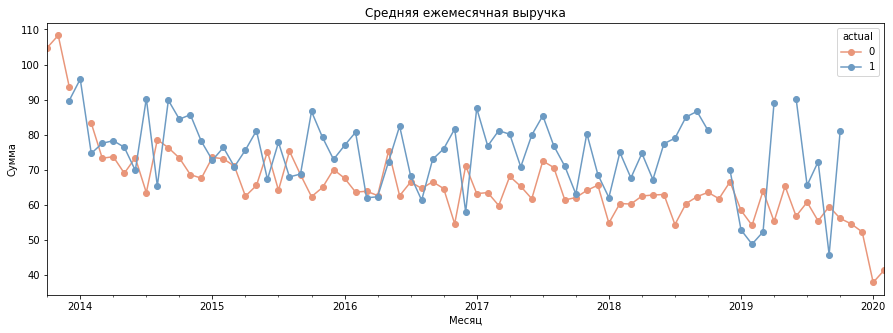

In [47]:
(final_data.pivot_table(index='actual', columns='begin_date', values='monthly_charges', aggfunc='mean')
                        .T.plot(kind='line', figsize=(15,5),  style = '-o', color=['darksalmon','#6d9bc3']))
plt.title('Средняя ежемесячная выручка')
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.show();

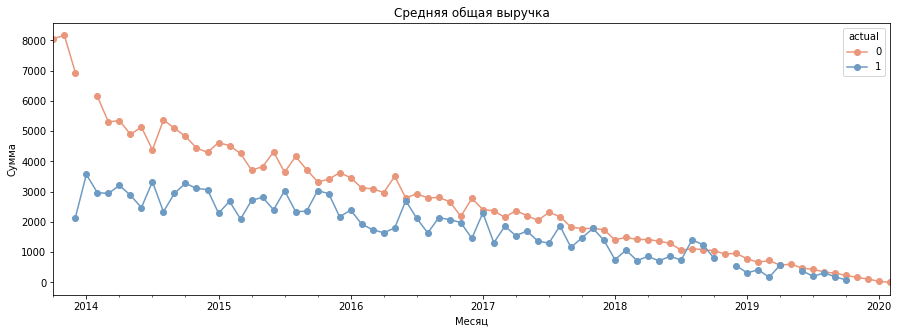

In [48]:
(final_data.pivot_table(index='actual', columns='begin_date', values='total_charges', aggfunc='mean')
  .T.plot(kind='line', figsize=(15,5),  style = '-o', color=['darksalmon','#6d9bc3']))
plt.title('Средняя общая выручка')
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.show();

Ежемесячный платеж ушедших клиентов был выше, в долгосрочном срезе оставшиеся клиенты приносят большую прибыль.

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
Более половины клиентов предпочитают оплачивать услуги каждый месяц (55%) по электронному расчётному листу (59%).<br/>
Способ оплаты распределен равномерно с небольгим перевесом в электронные платежи (34%).<br/>
    
Соотношение клиентов по гендеру в равной степени, 16% составляют пенсионеры.<br/>
Небольшой перевес в сторону несостояших в браке абонентов (52%), дети есть у 30%.
    
Интернет подключен у 78% абонентов, у большей части оптоволоконный кабель.<br/>
Отток клиентов составляет 16%.
    
В распределении времени действия договора наблюдаем наибольшее количество клиентов до года и более 6 лет, менее всего абонентов пользуются услугами в районе 3 лет.

Ежемесячный платеж ушедших клиентов был выше, в долгосрочном срезе оставшиеся клиенты приносят большую прибыль.

#### Абоненты, расторгнувшие договор

**Рассмотрим портрет абонента, который разорвал договор.**

In [49]:
nan_client = final_data.query('actual == 1') #срез по ушедшим клиентам

Срок действия расторгнутого договора в днях


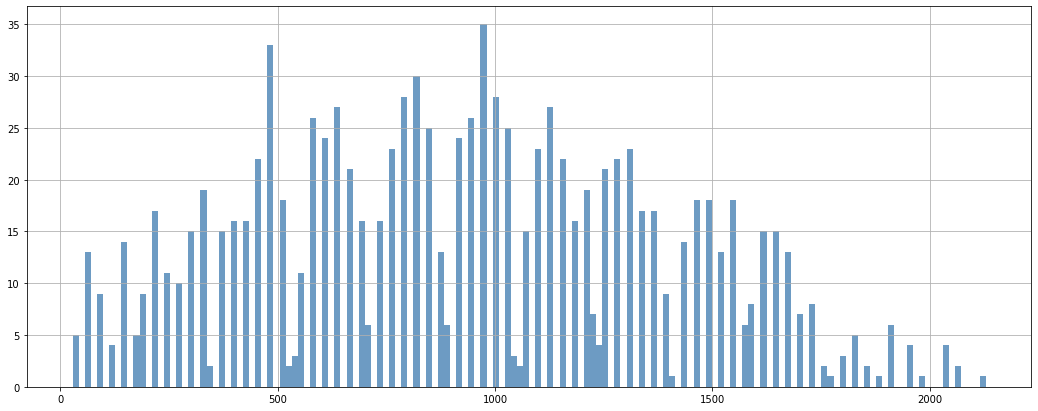

In [50]:
nan_client['total_days'].hist(figsize=(18, 7), bins=150, color='#6d9bc3')
print('Срок действия расторгнутого договора в днях')

Видим 2 заметных пика оттока клиетов после 16 месяцев и 2,5 лет

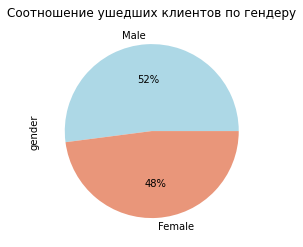

In [51]:
nan_client['gender'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение ушедших клиентов по гендеру');

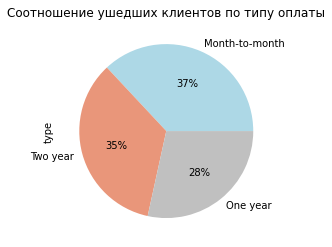

In [52]:
nan_client['type'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение ушедших клиентов по типу оплаты');

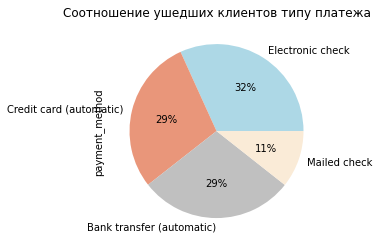

In [53]:
nan_client['payment_method'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение ушедших клиентов типу платежа');

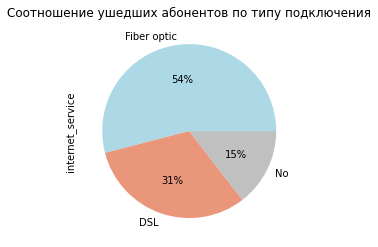

In [54]:
nan_client['internet_service'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%',
    figsize = (4,4),
    colors = my_colors,
    title = 'Соотношение ушедших абонентов по типу подключения');

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
Чаще абоненты разрывают договор после 16 месяцев и 2,5 лет. <br/>
Мужчины в 52%, в 37% абоненты оплачивали тариф ежемесячно. <br/>
Меньше всего ушедших клиентов с оплатой по электронному расчётному листу и подключенным интернетом через телефонную линию.

## Модели

### Подготовка

Ранее добавили новый столбец с количеством дней использования услуг, поэтому столбцы с датой начала и окончания договора можем удалить, как и идентификатор пользователя.

In [55]:
data = final_data.drop(columns = ['begin_date', 'end_date','customer_id'])

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   actual             7043 non-null   int64  
 6   total_days         7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_t_v      7043 

Оставим следующие столбцы для обучения: 
- тип оплаты 
- электронный расчётный лист
- тип платежа
- расходы за месяц
- общие расходы абонента
- актуальность абонента
- количество дней использования услуг
- подключение телефона к нескольким линиям одновременно 

type, paperless_billing, payment_method, monthly_charges, total_charges, actual, total_days, multiple_lines


In [57]:
data = data.drop(columns = ['gender','senior_citizen','partner','dependents','internet_service','online_security',
                            'online_backup','device_protection','tech_support','streaming_t_v','streaming_movies'])

In [58]:
data #проверим

,type,paperless_billing,payment_method,monthly_charges,total_charges,actual,total_days,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,No
1,One year,No,Mailed check,56.95,2071.84,0,1036,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,No
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,No
...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,2035.20,0,730,Yes
7039,One year,Yes,Credit card (automatic),103.20,7430.40,0,2191,Yes
7040,Month-to-month,Yes,Electronic check,29.60,325.60,0,337,No
7041,Month-to-month,Yes,Mailed check,74.40,520.80,0,215,Yes


Посмотрим матрицу корреляций

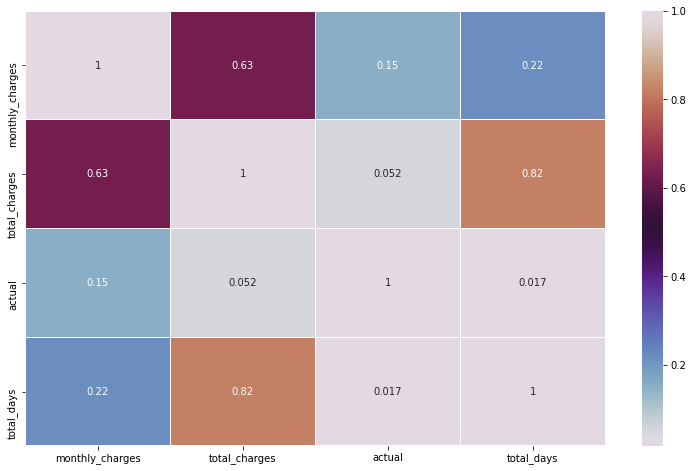

In [59]:
plt.figure(figsize=(13, 8))
sns.heatmap(data.corr(), annot=True, cmap='twilight', linewidths=.3)
plt.show()

Наиболее всего заметна корреляция между общими, ежемесячными тратами и продолжительностью договора, что объяснимо.

In [60]:
features = data.drop(columns=['actual']) #признаки и целевой признак
target = data['actual']

In [61]:
state = 310524 #зафиксируем random_state

Разобъем данные на обучающую и тестовую выборки

In [62]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size = 0.25,
                                                                            random_state=state)

In [63]:
features

,type,paperless_billing,payment_method,monthly_charges,total_charges,total_days,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,31,No
1,One year,No,Mailed check,56.95,2071.84,1036,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,123,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,1371,No
4,Month-to-month,Yes,Electronic check,70.70,353.50,153,No
...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,2035.20,730,Yes
7039,One year,Yes,Credit card (automatic),103.20,7430.40,2191,Yes
7040,Month-to-month,Yes,Electronic check,29.60,325.60,337,No
7041,Month-to-month,Yes,Mailed check,74.40,520.80,215,Yes


In [64]:
features_train.shape, features_test.shape #посмотрим размеры выборок

((5282, 7), (1761, 7))

Закодируем категориальные признаки и масштабируем численные

In [65]:
cat = ['type', 'paperless_billing', 'payment_method', 'multiple_lines']

In [66]:
num = ['monthly_charges', 'total_charges', 'total_days']

In [67]:
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(features_train[cat])

def features_ohe(ohe_variable, data_features, cat):
    data_features_ohe = pd.DataFrame(data=ohe_variable.transform(data_features[cat]),
                                     index=data_features.index, columns=ohe_variable.get_feature_names())

    data_features = data_features.drop(cat, axis=1)
    data_features = data_features.join(data_features_ohe)
    return data_features

features_train_ohe = features_ohe(ohe, features_train, cat)
features_test_ohe = features_ohe(ohe, features_test, cat)

In [68]:
features_train_ohe

,monthly_charges,total_charges,total_days,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_Yes
5795,106.40,4149.60,1187,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5694,51.45,1697.85,1006,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4334,76.40,874.02,337,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5496,24.25,1049.06,1279,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4005,24.05,105.82,123,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
6154,109.20,8019.65,2191,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3954,94.80,1627.72,518,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3484,83.45,3171.10,1157,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5035,78.80,1733.60,610,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [69]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[num])

features_train_ohe[num] = scaler.transform(features_train_ohe[num])
features_test_ohe[num] = scaler.transform(features_test_ohe[num])

In [70]:
features_train_ohe.shape, features_test_ohe.shape #посмотрим размеры преобразованных выборок

((5282, 10), (1761, 10))

### Обучение

**Logistic Regression**

In [71]:
lr = LogisticRegression(random_state=state, solver='liblinear')
f1_lr = cross_val_score(lr, features_train_ohe, target_train, cv=5, scoring='roc_auc').mean()
print('ROC-AUC:',f1_lr.round(3))

ROC-AUC: 0.741


**Random Forest Classifier**

In [72]:
param = {
    'n_estimators': [10, 50, 80],
    'max_depth': [4, 8, 13, 20],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2, 4]
}
rfc = RandomForestClassifier(random_state=state)
rfc_grid = GridSearchCV(rfc, param, cv=5, scoring='roc_auc')
rfc_grid.fit(features_train_ohe, target_train)

print('ROC-AUC:', rfc_grid.best_score_.round(3),features_train_ohe.shape[1])

ROC-AUC: 0.825 10


**Cat Boost Classifier**

In [73]:
param = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'iterations': [20, 200],
    'depth': [3, 5]
}
cbc = CatBoostClassifier(random_state=state, verbose=False)
cbc_grid = GridSearchCV(cbc, param, cv=5, scoring='roc_auc')
cbc_grid.fit(features_train_ohe, target_train)

print('ROC_AUC:', cbc_grid.best_score_.round(3),features_train_ohe.shape[1])

ROC_AUC: 0.904 10


**LightGBM Classifier**

In [74]:
param = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [5, 7, 9, 13]
}
lc = LGBMClassifier(random_state=state)
lc_grid = GridSearchCV(lc, param, cv=5, scoring='roc_auc')
lc_grid.fit(features_train_ohe, target_train)

print('ROC-AUC:', lc_grid.best_score_.round(3),features_train_ohe.shape[1])

ROC-AUC: 0.869 10


<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
ROC-AUC score:
    
- Logistic Regression 0.741
    
- Random Forest Classifier 0.825
    
- Cat Boost Classifier   0.904
    
- LightGBM Classifier 0.869

### Анализ моделей и тестирование

Целевым критерием оценки был ROC-AUC > 0.88.

Его удалось достичь модели Cat Boost Classifier c ROC-AUC score 0.904.
Протестируем.

In [75]:
metrics=pd.DataFrame(columns=['accuracy',
                              'f1_score',
                              'precision',
                              'recall'
                             ],
                     data=[[accuracy_score(target_test, cbc_grid.predict(features_test_ohe)),
                            f1_score(target_test, cbc_grid.predict(features_test_ohe)),
                            precision_score(target_test, cbc_grid.predict(features_test_ohe)),
                            recall_score(target_test, cbc_grid.predict(features_test_ohe))
                           ]]
                    )
print('Метрики модели Cat Boost Classifier на тестовой выборке')
metrics

Метрики модели Cat Boost Classifier на тестовой выборке


,accuracy,f1_score,precision,recall
0,0.927882,0.705336,0.904762,0.577947


In [76]:
best = cbc_grid.fit(features_train_ohe, target_train)
predicted = best.predict_proba(features_test_ohe)
predicted_test = predicted[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, predicted_test)
print('Метрика AUC-ROC модели Cat Boost Classifier на тестовой выборке',roc_auc_score(target_test, predicted_test).round(3))

Метрика AUC-ROC модели Cat Boost Classifier на тестовой выборке 0.919


In [77]:
cbc_grid.best_params_ #лучшие параметры модели

{'depth': 5, 'iterations': 200, 'learning_rate': 0.2}

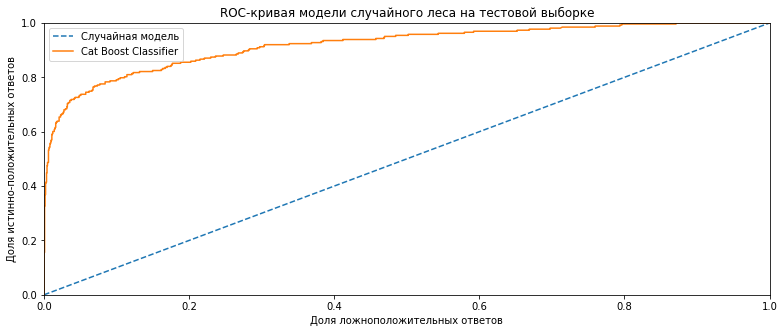

In [78]:
plt.figure(figsize = (13,5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.plot(fpr, tpr) #построим график
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно-положительных ответов')
plt.title('ROC-кривая модели случайного леса на тестовой выборке')
plt.legend(('Случайная модель', 'Cat Boost Classifier'))
plt.show()

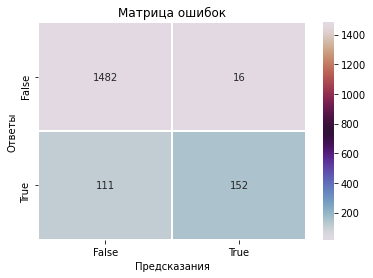

In [79]:
cbc_matrix = confusion_matrix(target_test, best.predict(features_test_ohe))
ax = sns.heatmap(cbc_matrix, annot=True, cmap='twilight', fmt="", linewidths=.3)

ax.set_title('Матрица ошибок');
ax.set_xlabel('Предсказания')
ax.set_ylabel('Ответы');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

**Посмотрим на важности признаков**

In [80]:
importances = pd.DataFrame(cbc_grid.best_estimator_.feature_importances_, index = features_train_ohe.columns, 
                           columns=['importances']).sort_values(by='importances', ascending=False)
importances

,importances
total_days,61.019907
total_charges,11.622298
monthly_charges,11.549175
x0_Two year,5.451670
x0_One year,2.899943
x3_Yes,2.078679
x2_Mailed check,2.065033
x2_Electronic check,1.234789
x1_Yes,1.087866
x2_Credit card (automatic),0.990641


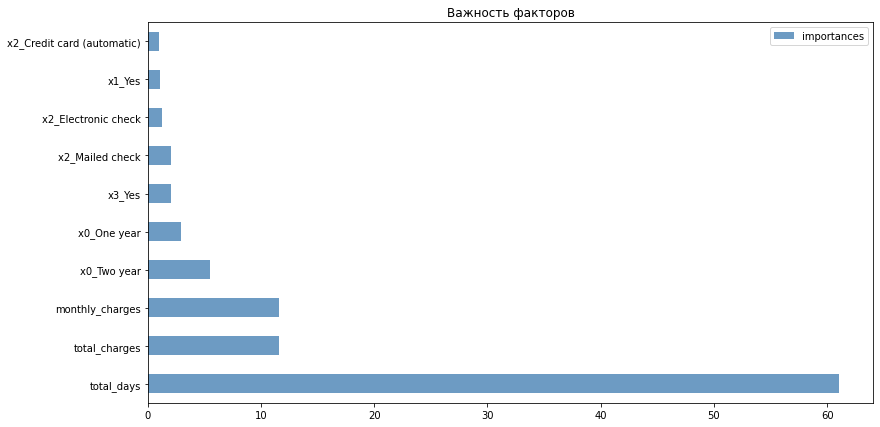

In [81]:
importances.plot(kind='barh', figsize=(13, 7), title='Важность факторов', color='#6d9bc3')
plt.show()

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
Целевым критерием оценки был ROC-AUC > 0.88.

Его удалось достичь модели Cat Boost Classifier c ROC-AUC score 0.904.

Метрики модели на тестовой выборке:
- доля правильных ответов 0.928
- f1-мера 0.705
- точность 0.905
- полнота 0.578 <br/>
    
Метрика AUC-ROC на тестовой выборке 0.919, были построены roc-кривая и матрица ошибок.

Среди важности признаков можем выделить:
- срок договора 61 %
- общие траты 11.6%
- ежемесячный платеж 11.5%
- тип оплаты раз в 2 года 5.5%<br/>
    
Остальные незначительны

## Вывод

### Отчет

<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
Наименование столбцов во всех датасетах привели к нижнему регистру и snake_case. <br/>
Дубликаты и пропуски отсутствуют.
    
*Информация о договоре* <br/>
Заменили формат даты с текстового в столбцах даты начала и дата окончания действия договора.<br/>
Столбец общих расходов абонента привели к числовому.

*Персональные данные клиента*<br/>
Количество строк в датасетах о  персональных данных клиентов и информации о договорах совпадает.
    
*Информация об интернет-услугах*<br/>
Не все абоненты пользуются интернет-услугами.

11 абонентов заключили договор в дату выгрузки датасета, пропуски заполнили 0.<br/>

Объединили данные по идентификатору абонента, есть пропуски в интернет-услугах (абоненты не подключали эту услугу), важна каждая строка, поэтому заполнили 0.<br/>


Ранее добавили новый столбец с количеством дней использования услуг, поэтому столбцы с датой начала и окончания договора можем удалить, как и идентификатор пользователя, удалили ряд других признаков.<br/>

Наиболее всего заметна корреляция между общими, ежемесячными тратами и продолжительностью договора, что объяснимо.
Преобразовали категориальные признаки кодированием One-Hot Encoding.<br/>

Закодировали категориальные признаки и масштабировали численные.
Отказались от балансировки целевого признака, модели переобучались.<br/>
    
Были обучены 4 модели.<br/>
ROC-AUC score:
    
- Logistic Regression   0.741
    
- Random Forest Classifier   0.825
    
- Cat Boost Classifier   0.904
    
- LightGBM Classifier   0.869     


Целевым критерием оценки был ROC-AUC > 0.88.

Его удалось достичь модели Cat Boost Classifier c ROC-AUC score 0.904.<br/>
    
Метрики модели на тестовой выборке:
- доля правильных ответов   0.928
- f1-мера   0.705
- точность   0.905
- полнота   0.578

Метрика AUC-ROC на тестовой выборке 0.919.
Были построены roc-кривая и матрица ошибок.

Среди важности признаков можем выделить:
- срок договора 61 %
- общие траты 11.6%
- ежемесячный платеж 11.5%
- тип оплаты раз в 2 года 5.5%    <br/> 
    
    Остальные незначительны

### Рекомендации

<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
Исследовав общий портрет клиента видим, что более половины клиентов предпочитают оплачивать услуги каждый месяц (55%) по электронному расчётному листу (59%). Способ оплаты распределен равномерно с небольгим перевесом в электронные платежи (34%).<br/>
    
Соотношение клиентов по гендеру в равной степени, 16% составляют пенсионеры.
Небольшой перевес в сторону несостояших в браке абонентов (52%), дети есть у 30%.
Интернет подключен у 78% абонентов, у большей части оптоволоконный кабель.
Отток клиентов составляет 16%.<br/>

В распределении времени действия договора наблюдаем наибольшее количество клиентов до года и более 6 лет (что говорит о лояльности клиентов), менее всего абонентов пользуются услугами в районе 3 лет. 
Ежемесячный платеж ушедших клиентов был выше, в долгосрочном срезе оставшиеся клиенты приносят большую прибыль.<br/>

Среди расторгнувших договор заметны 2 пика после 16 месяцев и 2,5 лет. Было ли повышение тарифа перед уходом у этих абонентов?<br/>
В 52% это мужчины, в 37% абоненты оплачивали тариф ежемесячно.
Меньше всего ушедших клиентов с оплатой по электронному расчётному листу и подключенным интернетом через телефонную линию. Как вариант рассмотреть специальное предложение для клиентов с подключенным интернетом, либо заморозка стоимости тарифа после 2-3 лет.
    
Важные факторы для рассмотрения:

- срок договора 61 %
- общие траты 11.6%
- ежемесячный платеж 11.5%
- тип оплаты раз в 2 года 5.5%
    
Остальные незначительно влияют на уход клиента.